In [53]:
# Import libraries and modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [54]:
# Load the data
df = pd.read_csv('stocks.csv')

In [55]:
# Convert all None values to NaN
df = df.replace('None', np.nan)

# Convert all - values to NaN
df = df.replace('-', np.nan)

# Remove any null values from the training set
df.dropna(inplace=True)

# Replace the boolean values in "outperformed" with 1 and 0
df['outperformed'].replace(True, 1, inplace=True)
df['outperformed'].replace(False, 0, inplace=True)

# Cast the columns to the correct data types
df = df.astype(
    {'market_cap': float, 'beta': float, 'ebitda': float, 'pe_ratio': float, 'peg_ratio': float, 'book_value': float,
     'trailing_pe': float, 'forward_pe': float, 'price_to_sales_ratio': float, 'dividend_per_share': float,
     'dividend_yield': float,
     'eps': float, 'price_to_book_ratio': float, 'ev_to_revenue': float, 'ev_to_ebitda': float})

In [56]:
# Drop the returns from both sets
df.drop(['stock_return_100', 'market_return_100'], axis=1, inplace=True)

# Drop the "Unnamed: 0" column from the training set
df.drop('Unnamed: 0', axis=1, inplace=True)

In [57]:
# Make the symbols the index
df.set_index('symbol', inplace=True)

df

,sentiment,market_cap,ebitda,pe_ratio,peg_ratio,book_value,dividend_per_share,dividend_yield,eps,revenue_per_share,...,quarterly_earnings_growth,quarterly_revenue_growth,trailing_pe,forward_pe,price_to_sales_ratio,price_to_book_ratio,ev_to_revenue,ev_to_ebitda,beta,outperformed
symbol,,,,,,,,,,,,,,,,,,,,,
A,0.221348,4.101120e+10,2.019000e+09,31.13,2.360,18.960,0.855,0.0065,4.44,23.270,...,0.279,0.049,31.13,26.95,6.500,8.630,6.920,24.870,1.0450,0
AAP,0.159260,7.208287e+09,1.037605e+09,14.71,0.909,45.490,6.000,0.0493,8.27,184.830,...,0.383,0.032,14.71,11.03,0.766,3.130,1.077,12.610,1.1370,0
AAPL,0.134550,2.620581e+12,1.252880e+11,28.17,2.750,3.581,0.910,0.0055,5.88,24.080,...,-0.105,-0.055,28.17,23.09,5.510,44.630,5.920,17.530,1.2970,1
ABB,0.225050,6.393383e+10,4.477000e+09,25.98,0.276,1.713,0.908,0.0268,1.32,3.877,...,-0.546,0.034,25.98,18.98,1.934,5.030,2.207,10.460,1.0240,1
ABBV,0.158136,2.843970e+11,3.108900e+10,24.32,1.279,9.750,5.710,0.0369,6.63,32.780,...,-0.388,0.016,24.32,14.39,4.989,18.230,6.040,13.800,0.5870,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTO,0.184920,2.325894e+10,1.040703e+10,23.40,23.960,66.760,0.000,0.0104,1.23,43.700,...,0.197,0.071,23.40,18.45,0.626,2.903,0.594,2.599,0.0137,1
ZTS,0.199179,7.741807e+10,3.332000e+09,37.21,3.526,9.500,1.300,0.0089,4.49,17.230,...,0.125,0.037,37.21,30.12,8.660,15.170,9.370,23.100,0.7590,1
ZUMZ,0.042960,3.716670e+08,5.122600e+07,17.18,0.820,20.900,0.000,0.0000,1.11,49.900,...,-0.651,-0.192,17.18,12.21,0.398,1.162,0.542,6.240,1.5010,0


In [58]:
# Get a list of models to evaluate
def get_models():
    models = dict()
    # lr
    rfe = RFE(estimator=LogisticRegression())
    model = DecisionTreeClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # perceptron
    rfe = RFE(estimator=Perceptron())
    model = DecisionTreeClassifier()
    models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier())
    model = DecisionTreeClassifier()
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier())
    model = DecisionTreeClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier())
    model = DecisionTreeClassifier()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    # ada
    rfe = RFE(estimator=AdaBoostClassifier())
    model = DecisionTreeClassifier()
    models['ada'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# Evaluate a model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

>lr 0.541 (0.047)
>per 0.544 (0.049)
>cart 0.549 (0.042)
>rf 0.550 (0.056)
>gbm 0.557 (0.043)
>ada 0.557 (0.041)


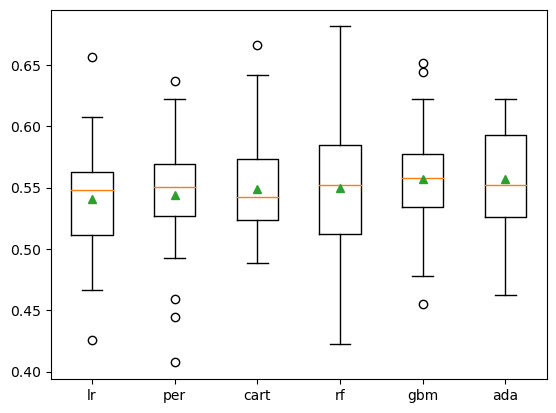

In [59]:
# Get the models to evaluate
models = get_models()

# Evaluate the models and store results

# Get the training data
X = df[df.columns[:-1]]

# Get the target data
y = df.iloc[:, -1]

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# Plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()